In [126]:
from glob import glob
import shutil
import pathlib
from PIL import Image

import tensorflow as tf
import tensorflow_hub as hub
import collections

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

import pandas as pd

from tensorflow.keras.optimizers import SGD


from sklearn.metrics import classification_report, confusion_matrix

In [44]:
imgs = glob('remojo_data/*/*/*')
imgs[:10]

['remojo_data/3/unclear/Windows_0005_10470.jpg',
 'remojo_data/3/porn/xiaomi_mi9_portrait_0009_01650.jpg',
 'remojo_data/3/porn/Samsung_GalaxyA30s_Landscape_0028_08149.jpg',
 'remojo_data/3/porn/Samsung_GalaxyJ7_Prime_landscape_0009_01827.jpg',
 'remojo_data/3/porn/Samsung_GalaxyJ7_Prime_portrait_0004_09248.jpg',
 'remojo_data/3/porn/Realme3_RMX1821_portrait_0021_05776.jpg',
 'remojo_data/3/porn/Samsung_GalaxyA31_Portrait_0010_06302.jpg',
 'remojo_data/3/porn/Realme3_RMX1821_portrait_0015_10526.jpg',
 'remojo_data/3/porn/Realme3_RMX1821_portrait_0020_05586.jpg',
 'remojo_data/3/porn/Realme3_RMX1821_Landscape_0032_12720.jpg']

In [45]:
flist = []
for f in imgs:
    ff = f.split('/')
    flist.append({
        'fname': ff[-1],
        'fclass': ff[-2],
        'annotator': ff[-3]
    })

In [46]:
df = pd.DataFrame(flist)
df

,fname,fclass,annotator
0,Windows_0005_10470.jpg,unclear,3
1,xiaomi_mi9_portrait_0009_01650.jpg,porn,3
2,Samsung_GalaxyA30s_Landscape_0028_08149.jpg,porn,3
3,Samsung_GalaxyJ7_Prime_landscape_0009_01827.jpg,porn,3
4,Samsung_GalaxyJ7_Prime_portrait_0004_09248.jpg,porn,3
...,...,...,...
10209,Samsung_GalaxyA31_Portrait_0008_02544.jpg,hentai,1
10210,xiaomi_mi9_landscape_0010_08250.jpg,hentai,1
10211,Samsung_GalaxyA30s_Portrait_0022_01856.jpg,hentai,1
10212,Samsung_GalaxyA30s_Portrait_0022_06400.jpg,hentai,1


In [47]:
df.annotator.value_counts()

1    2714
4    2500
3    2500
2    2500
Name: annotator, dtype: int64

In [48]:
df.fclass.value_counts()

porn        4674
neutral     3374
unclear      991
hentai       539
drawings     327
sexy         309
Name: fclass, dtype: int64

In [49]:
dfg = df.groupby(df.fname).agg(
    {
 'fclass':lambda x: ';'.join(x),
 'annotator': lambda x: ';'.join(x)
    }
)
dfg

,fclass,annotator
fname,,
2021-03-03-11-58-15_00432.jpg,porn;porn,3;1
2021-03-03-11-58-15_00576.jpg,porn;porn,3;2
2021-03-03-11-58-15_00672.jpg,porn;unclear,2;4
2021-03-03-11-58-15_00792.jpg,porn;porn,3;1
Huawei_Nova5T_portrait_0001_00279.jpg,porn;sexy,2;4
...,...,...
xiaomi_mi9_portrait_0010_06930.jpg,porn;porn,3;1
xiaomi_mi9_portrait_0010_07530.jpg,porn;porn,3;2
xiaomi_mi9_portrait_0010_08820.jpg,porn;porn,4;1


In [50]:
dfg['file_class_1'] = dfg.fclass.apply(lambda x: x.split(';')[0])
dfg['file_class_2'] = dfg.fclass.apply(lambda x: x.split(';')[1] if len(x.split(';'))>1 else None)
dfg['folder_1'] = dfg.annotator.apply(lambda x: x.split(';')[0])
dfg['folder_2'] = dfg.annotator.apply(lambda x: x.split(';')[1] if len(x.split(';'))>1 else None)

In [51]:
dfg[dfg.file_class_1==dfg.file_class_2]

,fclass,annotator,file_class_1,file_class_2,folder_1,folder_2
fname,,,,,,
2021-03-03-11-58-15_00432.jpg,porn;porn,3;1,porn,porn,3,1
2021-03-03-11-58-15_00576.jpg,porn;porn,3;2,porn,porn,3,2
2021-03-03-11-58-15_00792.jpg,porn;porn,3;1,porn,porn,3,1
Huawei_Nova5T_portrait_0001_01178.jpg,porn;porn,3;2,porn,porn,3,2
Huawei_Nova5T_portrait_0001_03410.jpg,porn;porn,3;2,porn,porn,3,2
...,...,...,...,...,...,...
xiaomi_mi9_portrait_0010_06930.jpg,porn;porn,3;1,porn,porn,3,1
xiaomi_mi9_portrait_0010_07530.jpg,porn;porn,3;2,porn,porn,3,2
xiaomi_mi9_portrait_0010_08820.jpg,porn;porn,4;1,porn,porn,4,1


In [52]:
!rm -rf remojo_matched
!mkdir remojo_matched

In [65]:
for row in dfg[dfg.file_class_1==dfg.file_class_2].iterrows():
    shutil.copy(f'remojo_data/{row[1][4]}/{row[1][2]}/{row[0]}', f'remojo_matched/{row[1][2]}/{row[0]}')

## Evaluate

## Remojo Imgs

In [130]:
test_dir = "remojo_matched"

datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=(224, 224), batch_size=4, interpolation="bilinear")

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_directory(test_dir, shuffle=True, **dataflow_kwargs)

Found 3108 images belonging to 5 classes.


In [131]:
resnet = tf.keras.models.load_model('nsfw_model/trained_models/resnet_v2_50_224/saved_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [132]:
resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
_________________________________________________________________
prediction (Activation)      (None, 5)                 0         
Total params: 23,575,045
Trainable params: 23,529,605
Non-trainable params: 45,440
_________________________________________________________________


In [133]:
resnet.compile(optimizer=SGD(momentum=.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [134]:
resnet.load_weights('nsfw_model/trained_models/resnet_v2_50_224/saved_model_weights.h5')
resnet.trainable=False

In [135]:
resnet.evaluate(test_generator)

777/777 [==============================] - 75s 95ms/step - loss: 6.4579 - accuracy: 0.4213


[6.615221977233887, 0.4086229205131531]

In [136]:
resnet_pred = resnet.predict(test_generator)


In [138]:
indexed_labels = [(index, label) for label, index in test_generator.class_indices.items()]
sorted_indices, sorted_labels = zip(*sorted(indexed_labels))
sorted_labels

('drawings', 'hentai', 'neutral', 'porn', 'sexy')

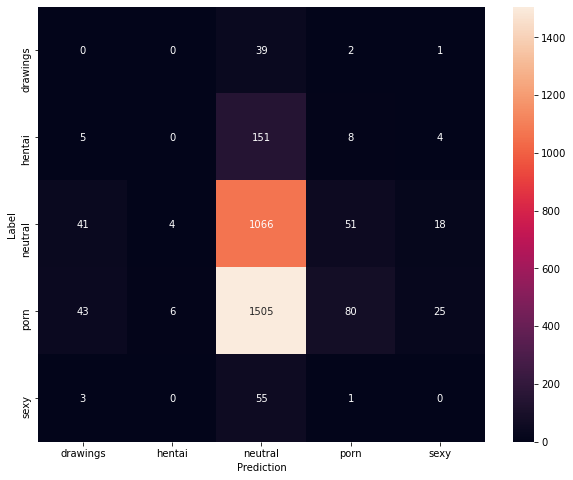

In [141]:
# resnet_pred = np.argmax(resnet_pred, 1)
confusion_mtx = tf.math.confusion_matrix(test_generator.classes, resnet_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=sorted_labels, yticklabels=sorted_labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## test imgs

In [142]:
test_dir = "test"

datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=(224, 224), batch_size=16, interpolation="bilinear")

test_datagen_1 = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
test_generator_1 = test_datagen.flow_from_directory(test_dir, shuffle=True, **dataflow_kwargs)

Found 9999 images belonging to 5 classes.


In [143]:
resnet.evaluate(test_generator_1)

625/625 [==============================] - 541s 866ms/step - loss: 0.3371 - accuracy: 0.8874


[0.3370817005634308, 0.8873887658119202]

In [ ]:
resnet_pred = resnet.predict(test_generator_1)

In [ ]:
resnet_pred = np.argmax(resnet_pred, 1)
confusion_mtx = tf.math.confusion_matrix(test_generator_1.classes, resnet_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=sorted_labels, yticklabels=sorted_labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()